In [1]:
import sys
sys.path.append(r"C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages")
import os
from pathlib import Path
import json
import random
import numpy as np
import spacy


from tqdm import tqdm
import pickle
import spacy
import json
import random
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
from spacy.language import Language
from luima_sbd import sbd_utils as luima
import seaborn as sns
import plotly.express as px
import math
import fasttext

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import random

random.seed(42)
np.random.seed(42)

%matplotlib inline

# Step 5.1: TF-IDF Featurization

## Some necessary functions

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs


def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

In [4]:
nlp = spacy.load("en_core_web_sm")
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])

def custom_spacy_tokenize(txt):
    nlp.disable_pipes('parser')
    doc = nlp.pipe(txt, n_process=4)
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    
#     print(txt)
    for i, token in enumerate(tokens):
#         print(token)
#         print(f"token: {token} | {token.pos_}")
        if token.pos_ == 'PUNCT' and not re.search("^[0-9]{2}/[0-9]{2}/([0-9]{2}|[0-9]{4})$", token.text):
            pass
        
        elif token.pos_ == 'NUM':
            refined_token = re.sub(r'\W', '', token.text)
            clean_tokens.append(f'<NUM{len(refined_token)}>')
            
        elif token.text == "\'s" and token.pos_ == 'PART':
#             continue
#             print(clean_tokens)
#             print(token, tokens[i-1])
            pos_token = tokens[i-1].text + token.text
            clean_tokens.pop(len(clean_tokens)-1)
            clean_tokens.append(pos_token.lower())
            
            
#             clean_tokens.remove(tokens[i-1].text.lower())
            
#             refined_token = re.sub(r'\W', '', pos_token.lower())
            
#             if refined_token.isnumeric():
#                 refined_token = f'<NUM{len(refined_token)}>'
                
#             if not refined_token == "":
#                 print(f"refined token = {refined_token}")
#                 clean_tokens.append(pos_token.lower())
#                 clean_tokens.remove(tokens[i-1].text.lower())
                   
        elif "-" in token.text:
            splitted_tokens = token.text.split("-")

            for sp_token in splitted_tokens:
                refined_token = re.sub(r'\W', '', sp_token.lower())
                if refined_token != "":
                    if refined_token.isnumeric():
                        refined_token = f'<NUM{len(refined_token)}>'
                    clean_tokens.append(refined_token)
        elif token.text in ("Vet. App.", "Fed. Cir."):
            clean_tokens.append(token.lemma_.lower())
#         elif "." in token.text and token.text in ("Vet. App.", "Fed. Cir."):
#             print(f"Special condition fulfilled: {token.text}")
#             splitted_tokens = token.text.split(".")

#             for sp_token in splitted_tokens:
#                 refined_token = re.sub(r'\W', '', sp_token.lower())
#                 if refined_token != "":
#                     if refined_token.isnumeric():
#                         refined_token = f'<NUM{len(refined_token)}>'
#                     clean_tokens.append(refined_token)
        else:
            refined_token = re.sub(r'\W', '', token.lemma_.lower())
#             print(f"refined token: {refined_token}")
            if re.search('\d+', refined_token) and re.search('[a-zA-Z]+', refined_token):
#                 print("Matched mixed")
                continue
            elif refined_token != "" and refined_token.isnumeric():
#                 print("Matched digit only")
                refined_token = f'<NUM{len(refined_token)}>'
                clean_tokens.append(refined_token)

            elif refined_token != "":
#                 print(f"Nothing matched, inserting {refined_token}")
                clean_tokens.append(refined_token)
                    
    return clean_tokens

def custom_spans_add_spacy_tokens(spans):
    for s in tqdm(spans):
        s['tokens_spacy'] = custom_spacy_tokenize(s['txt'])
        s['token_count'] = len(s['tokens_spacy'])

In [5]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations, doc_ids):
    span_data = []
    for doc_id in doc_ids:
        for a in annotations:
            if a['document'] == doc_id:
                start = a['start']
                end = a['end']
                document_txt = documents_by_id[a['document']]['plainText']
                atype = a['type']
                sd = {'txt': document_txt[start:end],
                      'document': a['document'],
                      'type': types_by_id[atype]['name'],
                      'start': a['start'],
                      'start_normalized': a['start'] / len(document_txt),
                      'end': a['end']}
                span_data.append(sd)
    return span_data

#### Data loading and preparation

In [6]:
# Loading the JSON file containing the data and the annotations
CURATED_ANN_PATH = "../Data/ldsi_w2021-20220221T223611Z-001/ldsi_w2021/ldsi_w21_curated_annotations_v2.json"
with open(CURATED_ANN_PATH, 'r') as j:
     data = json.loads(j.read())
        
data.keys()

dict_keys(['documents', 'annotations', 'types'])

In [7]:
annotations = data['annotations']
documents_by_id = {d['_id']: d for d in data['documents']}
types_by_id = {t['_id']: t for t in data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in data['types']}
type_names_by_id = {t['_id']: t['name'] for t in data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in data['documents']}

##### Loading the train, dev and test ids saved in phase 1

In [8]:
train_ids, dev_ids, test_ids = np.load('../Data/train.npy'), np.load('../Data/dev.npy'), np.load('../Data/test.npy')
train_ids.shape, dev_ids.shape, test_ids.shape

((113,), (14,), (14,))

In [9]:
# Creating train, dev and test spans
train_spans = make_span_data(documents_by_id, types_by_id, annotations, train_ids)
dev_spans = make_span_data(documents_by_id, types_by_id, annotations, dev_ids)
test_spans = make_span_data(documents_by_id, types_by_id, annotations, test_ids)

train_spans_txt = [s['txt'] for s in train_spans]
dev_spans_txt = [s['txt'] for s in dev_spans]
test_spans_txt = [s['txt'] for s in test_spans]


train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])
dev_spans_labels = np.array([s['type'] for s in dev_spans])
len(train_spans), len(dev_spans), len(test_spans), len(train_spans_txt), len(dev_spans_txt), len(test_spans_txt) 

(12450, 1376, 1523, 12450, 1376, 1523)

##### Adding the spacy tokens to the span data: contains two fields now, txt and the spacy tokens

In [10]:
custom_spans_add_spacy_tokens(train_spans)
custom_spans_add_spacy_tokens(dev_spans)
custom_spans_add_spacy_tokens(test_spans)

100%|█████████████████████████████████████████████████████████████████████████| 1523/1523 [00:06<00:00, 245.35it/s]


### TF-IDF featurization with Spacy's custom tokenizer

In [11]:
# suboptimal: tokenizer gets called twice
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_spacy_tokenize,
                                         min_df=3,
                                         ngram_range=(1,1))

spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_spans_txt)

tfidf_features_spacy = spacy_tfidf_vectorizer.get_feature_names_out()

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
print(len(tfidf_features_spacy))

3050


##### Extending the TF-IDF feature vectors

In [13]:
print(train_spans[0])

{'txt': 'Citation Nr: 0922385\t\r\nDecision Date: 06/15/09    Archive Date: 06/23/09\r\n\r\nDOCKET NO.  06-34 165A\t)\tDATE\r\n\t)\r\n\t)', 'document': '61aea55c97ad59b4cfc412af', 'type': 'CaseHeader', 'start': 0, 'start_normalized': 0.0, 'end': 113, 'tokens_spacy': ['citation', 'nr', '<NUM7>', 'decision', 'date', '<NUM6>', 'archive', 'date', '<NUM6>', 'docket', 'no', '<NUM2>', '<NUM2>', 'date'], 'token_count': 14}


In [14]:
# Extend by adding a a single float variable representing the number of tokens in the sentence, normalized
# by subtracting the mean and dividing by the standard deviation across all sentence
# tokens counts in the training data

df = pd.DataFrame([s['token_count'] for s in train_spans])
df.columns = ['token_count']
token_count_mean, token_count_std = df['token_count'].mean(), df['token_count'].std()

In [15]:
print(token_count_mean, token_count_std)

21.035180722891567 15.719815094996603


##### Expand the train data

In [16]:
# numpy feature vector extension
train_tfidf_spacy = spacy_tfidf_vectorizer.transform(train_spans_txt).toarray()
print(train_tfidf_spacy.shape)

train_starts_normalized = np.array([s['start_normalized'] for s in train_spans])
print(train_starts_normalized.shape)
print(np.expand_dims(train_starts_normalized, axis=1).shape)

token_count_normalized = np.array([(s['token_count']-token_count_mean)/token_count_std for s in train_spans])
print(token_count_normalized.shape)
print(np.expand_dims(token_count_normalized, axis=1).shape)

ext = np.concatenate((train_tfidf_spacy, np.expand_dims(train_starts_normalized, axis=1), np.expand_dims(token_count_normalized, axis=1)), axis=1)
print(ext.shape)

(12450, 3050)
(12450,)
(12450, 1)
(12450,)
(12450, 1)
(12450, 3052)


In [17]:
span_top_tfidf(train_spans_txt, 
               train_tfidf_spacy,
               tfidf_features_spacy,
               random.randint(0, len(train_spans)))

span text:
However, the question mark indicates that the diagnosis was uncertain, and suggests that further evaluation was needed.

       feature     tfidf
0         mark  0.449907
1      suggest  0.338715
2     question  0.309177
3   evaluation  0.303549
4      further  0.298051
5         need  0.296466
6      however  0.260905
7     indicate  0.250314
8         that  0.243991
9    diagnosis  0.234607
10          be  0.188150
11         the  0.156404
12         and  0.115035
13      expect  0.000000
14  experience  0.000000


In [18]:
dfs = top_features_by_class(train_tfidf_spacy, 
                            train_spans_labels,
                            tfidf_features_spacy)
dfs

{'CaseFooter':         feature     tfidf
 0             _  0.988602
 1       michael  0.003980
 2             t  0.003526
 3       veteran  0.003375
 4           act  0.002770
 5        affair  0.002696
 6         judge  0.002601
 7    department  0.002198
 8           law  0.002143
 9        appeal  0.001849
 10           of  0.001810
 11        board  0.001494
 12  experienced  0.000000
 13       expert  0.000000
 14       expect  0.000000
 15    expertise  0.000000
 16   experience  0.000000
 17     expert's  0.000000
 18         zone  0.000000
 19     existing  0.000000
 20    existence  0.000000
 21      existed  0.000000
 22  explanation  0.000000
 23        exist  0.000000
 24      exhibit  0.000000,
 'CaseHeader':        feature     tfidf
 0         date  0.588485
 1       <NUM6>  0.415193
 2     citation  0.251116
 3      archive  0.251116
 4           nr  0.250354
 5       docket  0.246732
 6       <NUM7>  0.243383
 7       <NUM2>  0.236265
 8     decision  0.176055
 9       

##### Make extended feature vectors for train, dev and test data

In [19]:
def make_tfidf_feature_vectors_and_labels(spans, vectorizer):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    
    df = pd.DataFrame([s['token_count'] for s in spans])
    df.columns = ['token_count']
    token_count_mean, token_count_std = df['token_count'].mean(), df['token_count'].std()

    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    token_count_normalized = np.array([(s['token_count']-token_count_mean)/token_count_std for s in spans])
#     num_tokens = np.array([len(s['tokens_spacy']) for s in spans])

    y = np.array([s['type'] for s in spans])
    X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1), np.expand_dims(token_count_normalized, axis=1)), axis=1)
    return X, y

In [20]:
train_X_tfidf, train_y_tfidf = make_tfidf_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
dev_X_tfidf, dev_y_tfidf = make_tfidf_feature_vectors_and_labels(dev_spans, spacy_tfidf_vectorizer)
test_X_tfidf, test_y_tfidf = make_tfidf_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)

In [21]:
print(f'{train_X_tfidf.shape} {train_y_tfidf.shape}')
print(f'{dev_X_tfidf.shape} {dev_y_tfidf.shape}')
print(f'{test_X_tfidf.shape} {test_y_tfidf.shape}')

(12450, 3052) (12450,)
(1376, 3052) (1376,)
(1523, 3052) (1523,)


### Using fasttext word embeddings and extending it

In [22]:
def make_word_embedded_feature_vectors_and_labels(spans, model):
    df = pd.DataFrame([s['token_count'] for s in spans])
    df.columns = ['token_count']
    token_count_mean, token_count_std = df['token_count'].mean(), df['token_count'].std()
    
    print(f"mean token count across the sentences: {token_count_mean}, std of the token counts: {token_count_std}")
    final_word_vector = []
    for s in spans:
        if (len(s['tokens_spacy'])):
            word_vector = np.mean(np.array([model.get_word_vector(token) for token in s['tokens_spacy']]), axis=0)
            final_word_vector.append(word_vector)
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    token_count_normalized = np.array([(s['token_count']-token_count_mean)/token_count_std for s in spans])
#     print(f"final word vector shape: {np.array(final_word_vector).shape}")
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((np.array(final_word_vector), np.expand_dims(starts_normalized, axis=1), np.expand_dims(token_count_normalized, axis=1)), axis=1)
    return X, y

In [23]:
model = fasttext.load_model("../Data/ft_word_embedding_model.bin")
len(model.get_words(on_unicode_error='ignore'))

train_X_wv, train_y_wv = make_word_embedded_feature_vectors_and_labels(train_spans, model)
dev_X_wv, dev_y_wv = make_word_embedded_feature_vectors_and_labels(dev_spans, model)
test_X_wv, test_y_wv = make_word_embedded_feature_vectors_and_labels(test_spans, model)

mean token count across the sentences: 21.035180722891567, std of the token counts: 15.719815094996603
mean token count across the sentences: 20.736191860465116, std of the token counts: 16.197850309567713
mean token count across the sentences: 20.229809586342746, std of the token counts: 14.656011190776486


In [24]:
print(f'{train_X_wv.shape} {train_y_wv.shape}')
print(f'{dev_X_wv.shape} {dev_y_wv.shape}')
print(f'{test_X_wv.shape} {test_y_wv.shape}')

(12450, 102) (12450,)
(1376, 102) (1376,)
(1523, 102) (1523,)


##### A sanity check with a classifier

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.99      1.00       112
                        CaseHeader       1.00      0.99      1.00       115
                         CaseIssue       1.00      0.96      0.98       114
                          Citation       0.99      0.96      0.98      1983
                   ConclusionOfLaw       0.94      0.74      0.83       274
                          Evidence       0.74      0.91      0.82      3859
EvidenceBasedOrIntermediateFinding       0.77      0.53      0.63      1178
            EvidenceBasedReasoning       0.43      0.33      0.37       874
                            Header       0.96      0.99      0.98      1159
                         LegalRule       0.77      0.70      0.73      1549
              LegislationAndPolicy       0.98      0.34      0.51       135
              PolicyBasedReasoning       1.00      0.20      0.33        15
    

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


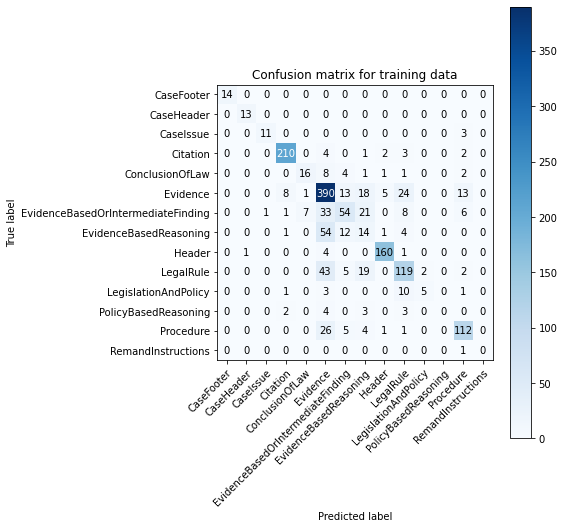

In [25]:
# With TF-IDF vectors

#clf = GaussianNB()
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(train_X_tfidf, train_y_tfidf)

print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X_tfidf)))
print('TEST:\n'+classification_report(dev_spans_labels, clf.predict(dev_X_tfidf)))

plot_confusion_matrix(test_spans_labels, clf.predict(test_X_tfidf), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       1.00      0.94      0.97       114
                          Citation       1.00      0.97      0.98      1983
                   ConclusionOfLaw       0.94      0.74      0.83       274
                          Evidence       0.85      0.92      0.89      3859
EvidenceBasedOrIntermediateFinding       0.64      0.64      0.64      1178
            EvidenceBasedReasoning       0.55      0.47      0.51       874
                            Header       0.99      0.99      0.99      1159
                         LegalRule       0.84      0.88      0.86      1549
              LegislationAndPolicy       0.82      0.47      0.60       135
              PolicyBasedReasoning       1.00      0.07      0.12        15
    

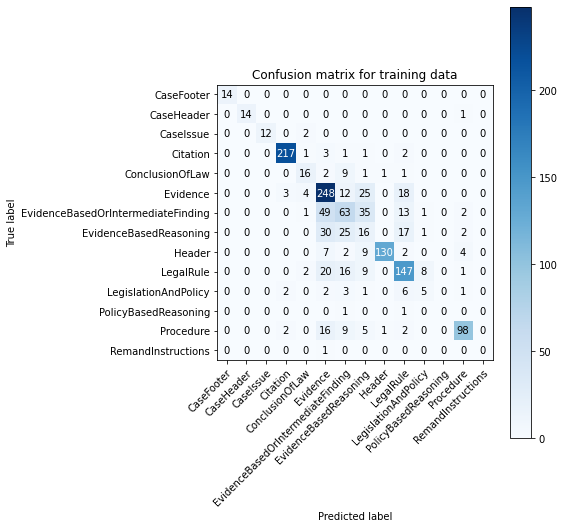

In [26]:
# With Word embedded vectors

#clf = GaussianNB()
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(train_X_wv, train_y_wv)

print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X_wv)))
print('TEST:\n'+classification_report(dev_spans_labels, clf.predict(dev_X_wv)))

plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X_wv), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

## Classification

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn import metrics

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [28]:
def trainWithCV(model, name, x_train, y_train, X_test, y_test):
    print("\nUsing {:s}\n".format(name))

    kf = StratifiedKFold(n_splits=5)
    cross_val_f1_score_lst = []
    cross_val_accuracy_lst = []
    cross_val_recall_lst = []
    cross_val_precision_lst = []
    cross_val_ba_lst = []
    clf = None
    for train_index_ls, validation_index_ls in kf.split(x_train, y_train):
        # keeping validation set apart and oversampling in each iteration using smote
        # train, validation = x_train[train_index_ls], x_train[validation_index_ls]
        train, validation = x_train[train_index_ls], x_train[validation_index_ls]
        target_train, target_val = y_train[train_index_ls], y_train[validation_index_ls]
#         from imblearn.combine import SMOTEENN
#         sm = SMOTEENN(random_state=42)
        # print('TRAIN = {:d}'.format(np.isnan(train).any()))
        # print('TARGET TRAIN = {:d}'.format(np.isnan(target_train).any()))
#         X_train_res, y_train_res = sm.fit_sample(train, target_train)
#         print(X_train_res.shape, y_train_res.shape)

        # training the model on oversampled 4 folds of training set
        clf = model
        clf.fit(x_train, y_train)
        # testing on 1 fold of validation set
        validation_preds = clf.predict(validation)
        cross_val_recall_lst.append(recall_score(target_val, validation_preds, average='macro'))
        cross_val_accuracy_lst.append(accuracy_score(target_val, validation_preds))
        cross_val_precision_lst.append(precision_score(target_val, validation_preds, average='macro'))
        cross_val_f1_score_lst.append(f1_score(target_val, validation_preds, average='macro'))
        cross_val_ba_lst.append(balanced_accuracy_score(target_val, validation_preds))

    bac_score = np.mean(cross_val_ba_lst)
    print('Cross validated BAC score: {}'.format(bac_score))
    print('Cross validated accuracy: {}'.format(np.mean(cross_val_accuracy_lst)))
    print('Cross validated recall score: {}'.format(np.mean(cross_val_recall_lst)))
    print('Cross validated precision score: {}'.format(np.mean(cross_val_precision_lst)))
    print('Cross validated f1_score: {}'.format(np.mean(cross_val_f1_score_lst)))

    predicted = clf.predict(X_test)
    print(metrics.classification_report(y_test, predicted))

    metrics.confusion_matrix(y_test, predicted)

    confusion_mat = confusion_matrix(y_test, predicted)
    print("Confusion Matrix : \n" + str(confusion_mat))

#     plot_precision_recall_curve(clf, X_test, y_test, ax=ax)

    return bac_score, clf

##### TODO: K-fold CV

In [29]:
model = LinearSVC(random_state=42, tol=1e-4)
bac_score, clf = trainWithCV(model, 'Linear SVC', train_X_tfidf, train_y_tfidf, dev_X_tfidf, dev_y_tfidf)


Using Linear SVC



C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\siyam\Des

Cross validated BAC score: 0.869859011784022
Cross validated accuracy: 0.9284337349397591
Cross validated recall score: 0.869859011784022
Cross validated precision score: 0.9237234264004398
Cross validated f1_score: 0.886420812665899
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       0.93      1.00      0.97        14
                          Citation       0.97      1.00      0.98       225
                   ConclusionOfLaw       0.85      0.77      0.81        30
                          Evidence       0.77      0.85      0.81       310
EvidenceBasedOrIntermediateFinding       0.68      0.63      0.65       164
            EvidenceBasedReasoning       0.30      0.19      0.23        91
                            Header       0.97      0.97      0.97       154
     

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

In [32]:
def train(model, x_train, y_train, X_test, y_test):
    print("\nUsing {:s}\n".format(model['name']))
    clf = model['model']
    model_ident = model['name']
    
    clf.fit(x_train, y_train)
    predicted = clf.predict(X_test)
    bac_score = balanced_accuracy_score(y_test, predicted)

    print('BAC score: {}'.format(bac_score))
    
    
    print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(x_train), zero_division=1))
    print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(X_test), zero_division=1))
    plot_confusion_matrix(dev_spans_labels, clf.predict(X_test), classes=list(clf.classes_),
                          title=f'Confusion matrix for {model_ident}')
    plt.show()
    print("--------------------------------------------------------------------------------------\n")
    
    
    
#     print(metrics.classification_report(y_test, predicted))
#     print("Confusion Matrix : \n" + str(confusion_matrix(y_test, predicted)))

#     plot_precision_recall_curve(clf, X_test, y_test, ax=ax)
    return bac_score, model

In [33]:
def run_train(X_train, y_train, X_test, y_test):
    models = [
        {
            'model': LinearSVC(random_state=42, tol=1e-4),
            'name': 'Linear SVC'
        },
        
        {
#             'model': LogisticRegression(max_iter=1000, C=5.2, class_weight='balanced', random_state=42),
            'model': LogisticRegression(random_state=42),
            'name': 'Logistic Regression'
        },
        
        {
            'model': SVC(kernel='rbf', random_state=42),
            'name': "Radial Kernet SVM"
        },
        
        {
            'model': SVC(kernel='sigmoid', random_state=42),
            'name': "Sigmoid Kernel SVM"
        },
        
        {
            'model': SVC(kernel='poly', random_state=42),
            'name': "Polynomial Kernel SVM"
        },
        
        {
            'model': DecisionTreeClassifier(max_depth=13, random_state=42),
            #  'model': DecisionTreeClassifier(criterion="entropy", splitter="random", max_features = 'log2', random_state=42),
            'name': 'Decision Tree'
        },
        
        {
            'model': RandomForestClassifier(
                n_estimators=20,
                max_depth=10,
                random_state=42
#                 , n_jobs=-1
                # , max_features='log2'
                # , class_weight={0: 1, 1: 2}
                # ,max_features=20
                # ,criterion='entropy'
            ),
            'name': 'Random Forest Classifier'
        },
        
    ]
    best_score, best_model = 0, None

    for m in models:
        bac_score, model = train(m, X_train, y_train, X_test, y_test)

        if bac_score > best_score:
            print('Current best model {:s}'.format(m['name']))
            best_score, best_model = bac_score, model

        # if m['name'] == 'Random Forest Classifier':
        #     print(rf_cv.best_params_)

#     plt.show()

    return best_score, best_model['model']

##### Classification with TF-IDF


Using Linear SVC



C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


BAC score: 0.6727700223017533
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.97      1.00      0.98       114
                          Citation       0.99      1.00      1.00      1983
                   ConclusionOfLaw       0.94      0.93      0.93       274
                          Evidence       0.91      0.97      0.94      3859
EvidenceBasedOrIntermediateFinding       0.84      0.80      0.82      1178
            EvidenceBasedReasoning       0.84      0.62      0.72       874
                            Header       0.99      0.99      0.99      1159
                         LegalRule       0.92      0.97      0.94      1549
              LegislationAndPolicy       0.82      0.53      0.64       135
              PolicyBasedReasoning       1.00     

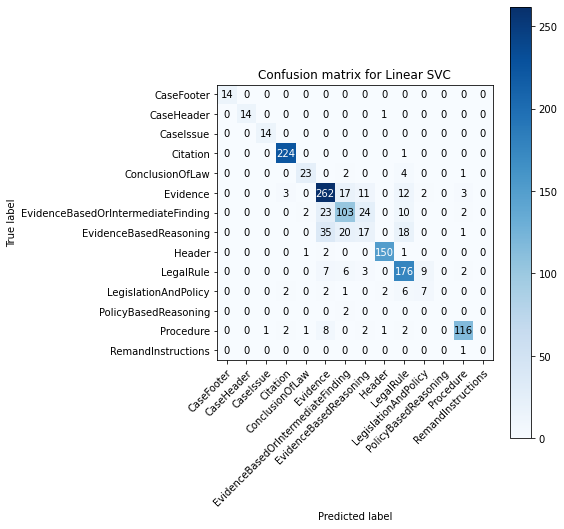

--------------------------------------------------------------------------------------

Current best model Linear SVC

Using Logistic Regression



C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BAC score: 0.666659290768799
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.98      0.99      0.99       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.93      0.97      0.95       114
                          Citation       0.98      0.98      0.98      1983
                   ConclusionOfLaw       0.91      0.82      0.86       274
                          Evidence       0.84      0.96      0.90      3859
EvidenceBasedOrIntermediateFinding       0.75      0.65      0.70      1178
            EvidenceBasedReasoning       0.72      0.43      0.53       874
                            Header       0.99      1.00      0.99      1159
                         LegalRule       0.87      0.93      0.90      1549
              LegislationAndPolicy       0.74      0.29      0.41       135
              PolicyBasedReasoning       1.00      

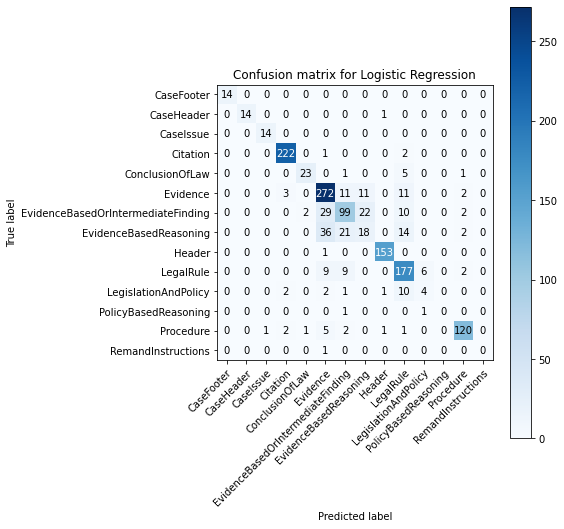

--------------------------------------------------------------------------------------


Using Radial Kernet SVM

BAC score: 0.6727525266042378
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.94      0.98      0.96       114
                          Citation       0.99      0.99      0.99      1983
                   ConclusionOfLaw       0.95      0.87      0.91       274
                          Evidence       0.87      0.98      0.92      3859
EvidenceBasedOrIntermediateFinding       0.86      0.77      0.81      1178
            EvidenceBasedReasoning       0.85      0.54      0.66       874
                            Header       0.99      1.00      0.99      1159
                         LegalRule       0.90      0.96      0.93      1549
            

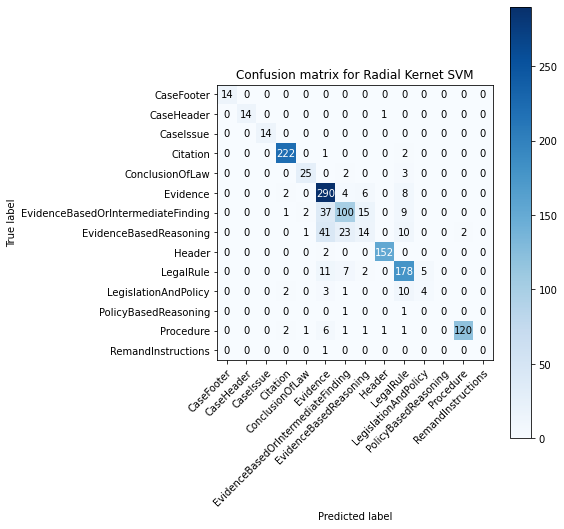

--------------------------------------------------------------------------------------


Using Sigmoid Kernel SVM

BAC score: 0.4407690723423304
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.03      0.01      0.01       112
                        CaseHeader       1.00      0.97      0.98       115
                         CaseIssue       0.93      0.74      0.82       114
                          Citation       0.88      0.85      0.86      1983
                   ConclusionOfLaw       0.31      0.51      0.39       274
                          Evidence       0.57      0.81      0.67      3859
EvidenceBasedOrIntermediateFinding       0.41      0.07      0.11      1178
            EvidenceBasedReasoning       0.15      0.29      0.20       874
                            Header       0.98      0.99      0.99      1159
                         LegalRule       0.58      0.22      0.32      1549
           

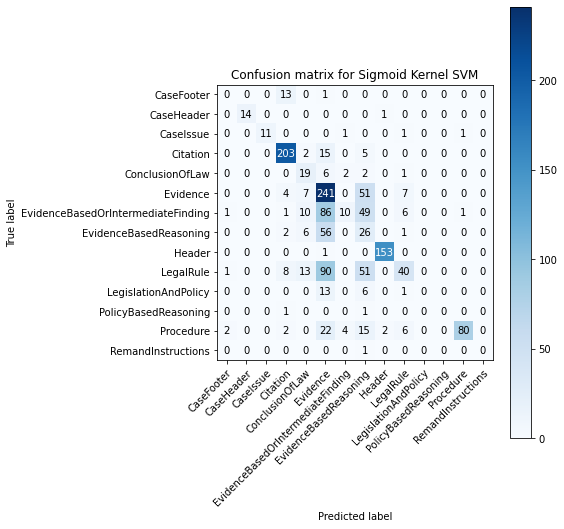

--------------------------------------------------------------------------------------


Using Polynomial Kernel SVM

BAC score: 0.5698891366742335
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       1.00      0.97      0.98       115
                         CaseIssue       0.96      0.57      0.71       114
                          Citation       1.00      0.97      0.98      1983
                   ConclusionOfLaw       0.97      0.64      0.77       274
                          Evidence       0.68      0.99      0.81      3859
EvidenceBasedOrIntermediateFinding       0.90      0.52      0.66      1178
            EvidenceBasedReasoning       0.95      0.51      0.66       874
                            Header       0.99      1.00      0.99      1159
                         LegalRule       0.95      0.77      0.85      1549
        

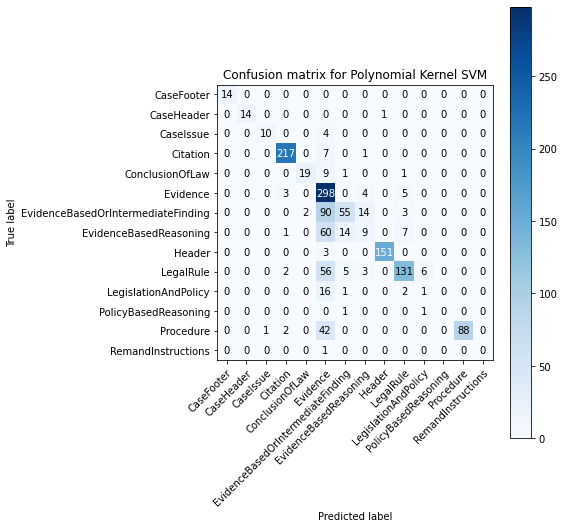

--------------------------------------------------------------------------------------


Using Decision Tree

BAC score: 0.5991205498763135
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.99      1.00       112
                        CaseHeader       1.00      0.99      1.00       115
                         CaseIssue       0.98      0.97      0.98       114
                          Citation       0.99      0.98      0.99      1983
                   ConclusionOfLaw       0.97      0.78      0.86       274
                          Evidence       0.77      0.90      0.83      3859
EvidenceBasedOrIntermediateFinding       0.79      0.57      0.66      1178
            EvidenceBasedReasoning       0.44      0.44      0.44       874
                            Header       0.96      0.99      0.98      1159
                         LegalRule       0.81      0.71      0.76      1549
              Le

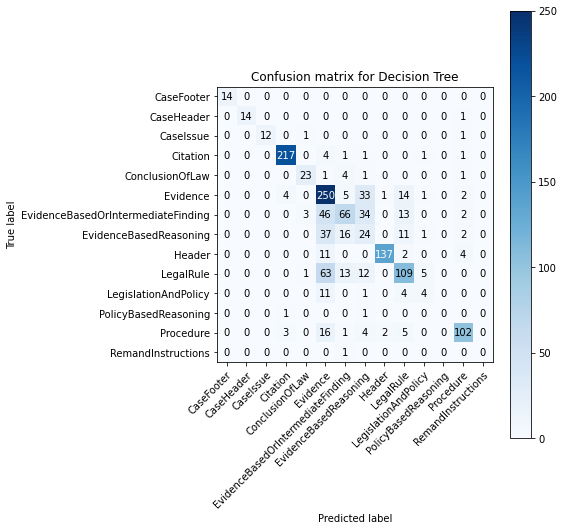

--------------------------------------------------------------------------------------


Using Random Forest Classifier

BAC score: 0.4019532419304738
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.94      0.97       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       1.00      0.01      0.02       114
                          Citation       0.99      0.96      0.97      1983
                   ConclusionOfLaw       1.00      0.04      0.07       274
                          Evidence       0.50      1.00      0.67      3859
EvidenceBasedOrIntermediateFinding       0.96      0.07      0.13      1178
            EvidenceBasedReasoning       1.00      0.00      0.00       874
                            Header       0.87      0.91      0.89      1159
                         LegalRule       0.93      0.47      0.62      1549
     

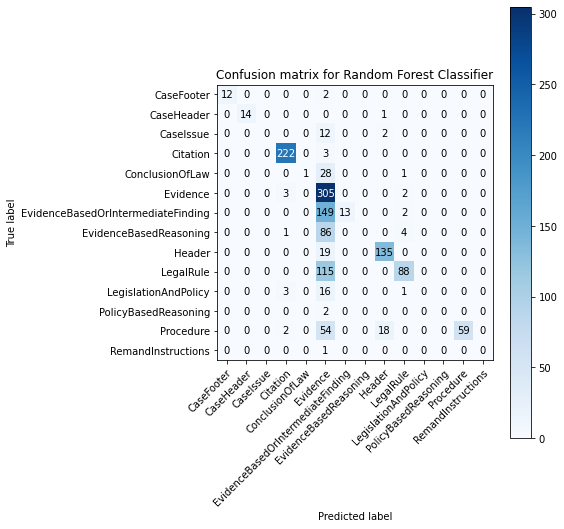

--------------------------------------------------------------------------------------

CPU times: total: 16min 5s
Wall time: 15min 33s
Best achieved score: 0.6727700223017533 with model: LinearSVC(random_state=42)


In [34]:
# Best achieved score: 0.6727700223017533 with model: LinearSVC(random_state=42)

%time best_score, best_model =  run_train(train_X_tfidf, train_y_tfidf, dev_X_tfidf, dev_y_tfidf)
print(f"Best achieved score: {best_score} with model: {best_model}")

##### Classification with Word embedding


Using Linear SVC



C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


BAC score: 0.6622287780315895
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       1.00      0.97      0.98       115
                         CaseIssue       0.91      0.97      0.94       114
                          Citation       0.98      0.98      0.98      1983
                   ConclusionOfLaw       0.84      0.76      0.80       274
                          Evidence       0.78      0.93      0.85      3859
EvidenceBasedOrIntermediateFinding       0.63      0.51      0.56      1178
            EvidenceBasedReasoning       0.55      0.16      0.25       874
                            Header       0.99      0.99      0.99      1159
                         LegalRule       0.78      0.90      0.84      1549
              LegislationAndPolicy       0.78      0.24      0.36       135
              PolicyBasedReasoning       1.00     

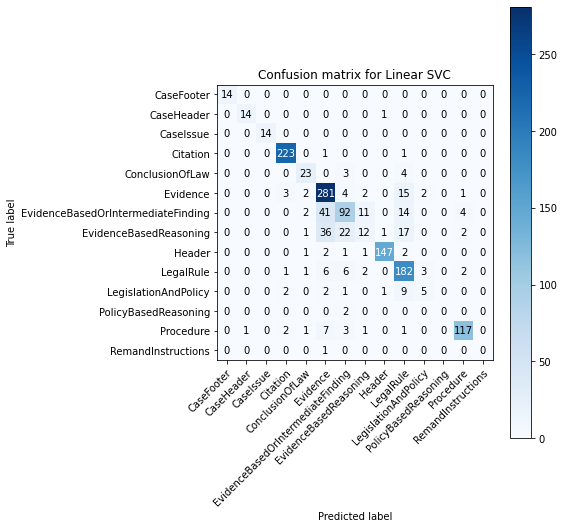

--------------------------------------------------------------------------------------

Current best model Linear SVC

Using Logistic Regression



C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BAC score: 0.6660827224839175
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       1.00      0.97      0.98       115
                         CaseIssue       0.89      0.97      0.93       114
                          Citation       0.98      0.97      0.98      1983
                   ConclusionOfLaw       0.87      0.73      0.79       274
                          Evidence       0.80      0.92      0.86      3859
EvidenceBasedOrIntermediateFinding       0.61      0.53      0.57      1178
            EvidenceBasedReasoning       0.52      0.28      0.36       874
                            Header       0.98      0.99      0.98      1159
                         LegalRule       0.81      0.89      0.85      1549
              LegislationAndPolicy       0.74      0.25      0.38       135
              PolicyBasedReasoning       1.00     

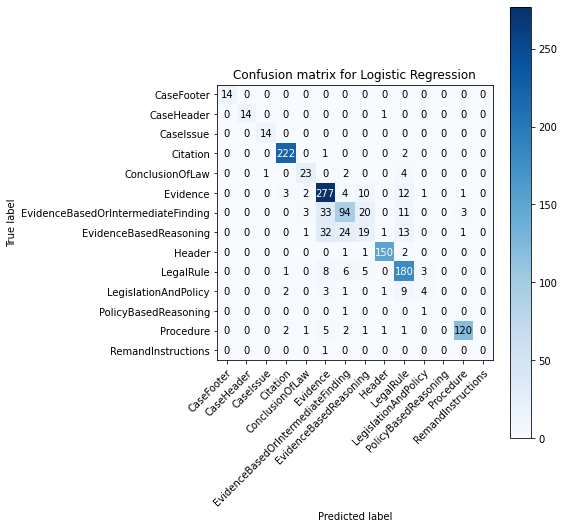

--------------------------------------------------------------------------------------

Current best model Logistic Regression

Using Radial Kernet SVM

BAC score: 0.6770927957747113
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       1.00      0.97      0.98       115
                         CaseIssue       0.93      0.98      0.95       114
                          Citation       0.99      0.98      0.99      1983
                   ConclusionOfLaw       0.89      0.80      0.84       274
                          Evidence       0.82      0.94      0.88      3859
EvidenceBasedOrIntermediateFinding       0.65      0.53      0.58      1178
            EvidenceBasedReasoning       0.54      0.29      0.38       874
                            Header       0.99      0.99      0.99      1159
                         LegalRule       0.82    

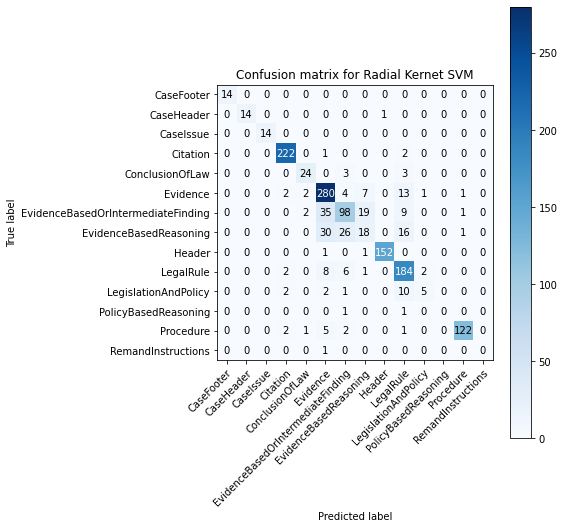

--------------------------------------------------------------------------------------

Current best model Radial Kernet SVM

Using Sigmoid Kernel SVM

BAC score: 0.414273479460614
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.00      0.00      0.00       112
                        CaseHeader       0.00      0.00      0.00       115
                         CaseIssue       0.76      0.68      0.72       114
                          Citation       0.76      0.90      0.82      1983
                   ConclusionOfLaw       0.26      0.53      0.35       274
                          Evidence       0.69      0.82      0.75      3859
EvidenceBasedOrIntermediateFinding       0.34      0.40      0.37      1178
            EvidenceBasedReasoning       0.36      0.05      0.10       874
                            Header       0.96      0.97      0.97      1159
                         LegalRule       0.73      

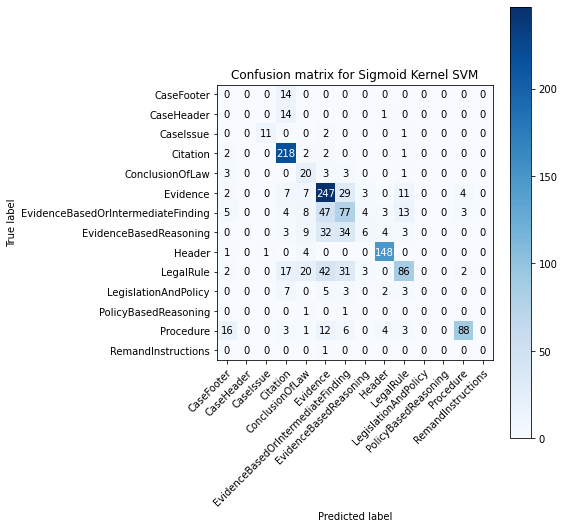

--------------------------------------------------------------------------------------


Using Polynomial Kernel SVM

BAC score: 0.6506734398633489
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       1.00      0.97      0.98       115
                         CaseIssue       0.97      0.84      0.90       114
                          Citation       0.99      0.98      0.98      1983
                   ConclusionOfLaw       0.89      0.63      0.74       274
                          Evidence       0.76      0.96      0.85      3859
EvidenceBasedOrIntermediateFinding       0.62      0.46      0.52      1178
            EvidenceBasedReasoning       0.55      0.19      0.29       874
                            Header       0.99      0.99      0.99      1159
                         LegalRule       0.82      0.89      0.85      1549
        

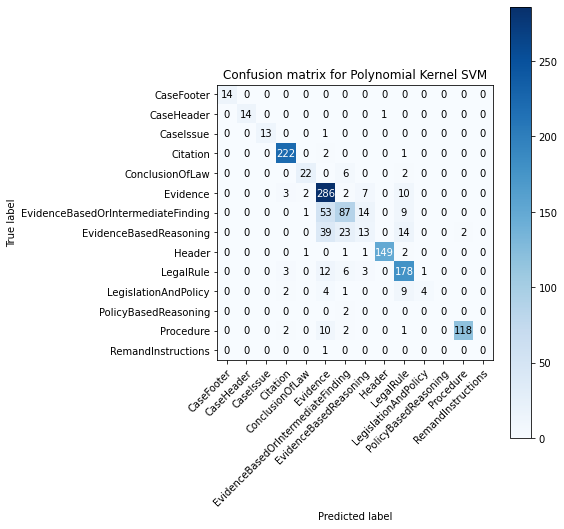

--------------------------------------------------------------------------------------


Using Decision Tree

BAC score: 0.5886691991086966
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.97      0.96      0.97       114
                          Citation       0.99      0.98      0.99      1983
                   ConclusionOfLaw       1.00      0.77      0.87       274
                          Evidence       0.87      0.95      0.91      3859
EvidenceBasedOrIntermediateFinding       0.73      0.70      0.71      1178
            EvidenceBasedReasoning       0.61      0.56      0.58       874
                            Header       0.99      1.00      0.99      1159
                         LegalRule       0.90      0.89      0.89      1549
              Le

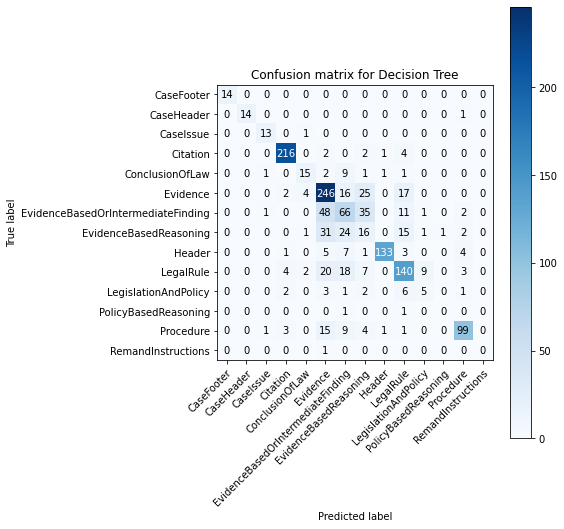

--------------------------------------------------------------------------------------


Using Random Forest Classifier

BAC score: 0.6289683252650234
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.99      0.96      0.97       114
                          Citation       1.00      0.97      0.98      1983
                   ConclusionOfLaw       0.96      0.72      0.82       274
                          Evidence       0.74      0.98      0.84      3859
EvidenceBasedOrIntermediateFinding       0.71      0.52      0.60      1178
            EvidenceBasedReasoning       0.92      0.07      0.12       874
                            Header       1.00      1.00      1.00      1159
                         LegalRule       0.82      0.89      0.85      1549
     

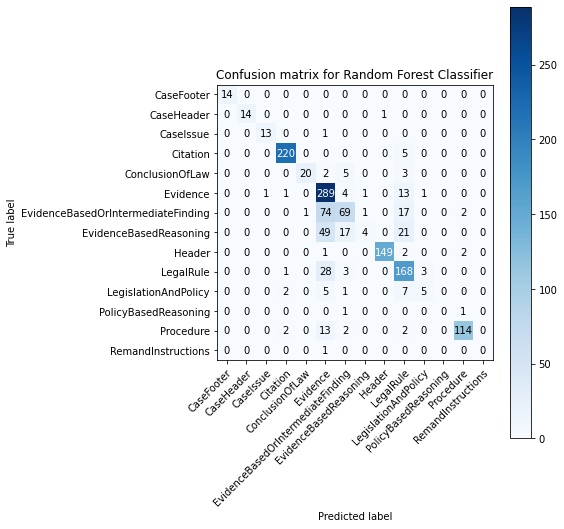

--------------------------------------------------------------------------------------

CPU times: total: 39.5 s
Wall time: 37.8 s
Best achieved score: 0.6770927957747113 with model: SVC(random_state=42)


In [35]:
# Best achieved score: 0.6770927957747113 with model: SVC(random_state=42)

%time best_score, best_model =  run_train(train_X_wv, train_y_wv, dev_X_wv, dev_y_wv)
print(f"Best achieved score: {best_score} with model: {best_model}")

##### Hyperparameter tuning for Non-Linear models

#### Decision Tree

In [ ]:
{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=13, random_state=0)
%time clf = clf.fit(train_X, train_y)
model_ident = "Decision Trees"
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title=f'Confusion matrix for {model_ident}')
plt.show()
clf.get_params()

#### SVC

In [60]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
# parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid')}
parameters = {'kernel':['linear'], 'C':[1, 3, 5, 7, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, verbose=3)
clf.fit(train_X_tfidf, train_y_tfidf)


sorted(clf.cv_results_.keys())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END ................C=1, kernel=linear;, score=0.844 total time= 1.2min
[CV 2/5] END ................C=1, kernel=linear;, score=0.824 total time= 1.2min
[CV 3/5] END ................C=1, kernel=linear;, score=0.827 total time= 1.2min
[CV 4/5] END ................C=1, kernel=linear;, score=0.842 total time= 1.2min
[CV 5/5] END ................C=1, kernel=linear;, score=0.834 total time= 1.2min
[CV 1/5] END ................C=3, kernel=linear;, score=0.834 total time= 1.2min
[CV 2/5] END ................C=3, kernel=linear;, score=0.812 total time= 1.1min
[CV 3/5] END ................C=3, kernel=linear;, score=0.811 total time= 1.2min
[CV 4/5] END ................C=3, kernel=linear;, score=0.829 total time= 1.2min
[CV 5/5] END ................C=3, kernel=linear;, score=0.823 total time= 1.1min
[CV 1/5] END ................C=5, kernel=linear;, score=0.823 total time= 1.1min
[CV 2/5] END ................C=5, kernel=linear;, score=0.806 total time= 1.0min
[CV 3/5] END ...............

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid')}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, verbose=3)
clf.fit(train_X_tfidf, train_y_tfidf)


sorted(clf.cv_results_.keys())

In [45]:
clf.cv_results_['mean_test_score']

array([0.83421687, 0.83317269, 0.74240964, 0.60457831])

In [48]:
dir(clf)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_

In [56]:
clf.best_score_, clf.best_params_

(0.8342168674698796, {'kernel': 'linear'})

In [ ]:
def prediction_errors(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_feature_vectors_and_labels(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

### Polynomial kernel SVM

In [ ]:
clf = SVC(kernel='sigmoid', random_state=0)
clf = clf.fit(train_X, train_y)
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
model_ident="Sigmoid Kernel SVM"
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title=f'Confusion matrix for {model_ident}')
plt.show()

## Best Model